In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [44]:
class Correlator:
    
    def __init__(self):
        self.image = None
        self.filter = None

    def __padding(self, horizontal_padding, vertical_padding):
        padded_image = np.zeros((self.image.shape[0] + 2 * vertical_padding, self.image.shape[1] + 2 * horizontal_padding, 3))
        
        if vertical_padding == 0:
            padded_image[:, horizontal_padding : -horizontal_padding, :] = self.image 
        elif horizontal_padding == 0:
            padded_image[vertical_padding : -vertical_padding, :, :] = self.image 
        else:
            padded_image[vertical_padding : -vertical_padding, horizontal_padding : -horizontal_padding, :] = self.image 
    
        return padded_image
        
    def apply_correlation(self, image_path, filter_matrix, zero_padding = True, normalization = False):
        self.image = np.array(Image.open(image_path).convert('RGB'))
        self.filter = filter_matrix

        epsilon = 1e-7
        
        vertical_padding = self.filter.shape[0]//2
        horizontal_padding = self.filter.shape[1]//2
        
        if not horizontal_padding and not vertical_padding:
            print("Could not execute padding due to filter shape. Try a Bi dimensional kernel.")
            zero_padding = False
        
        if zero_padding:
            preprocessed_img = self.__padding(horizontal_padding, vertical_padding)
            output = np.zeros((self.image.shape[0], self.image.shape[1], 3))
        else:
            preprocessed_img = self.image
            output = np.zeros((self.image.shape[0] - 2 * vertical_padding, self.image.shape[1] - 2 * horizontal_padding, 3))
    
        if not normalization:
            for i in range(preprocessed_img.shape[0] - self.filter.shape[0]):
                for j in range(preprocessed_img.shape[1] - self.filter.shape[1]):
                    for k in range(3):
                        output[i,j,k] = np.sum(np.multiply(self.filter, preprocessed_img[i: i + self.filter.shape[0], j: j + self.filter.shape[1], k]))
        else:
            filter_diff = self.filter - np.mean(self.filter)
            normalized_filter = filter_diff/np.sum(np.abs(filter_diff + epsilon))
            if np.argmax(normalized_filter) == 0:
                print("Warning : Filter has mean zero. Normalization will result in a black image.")

            for i in range(preprocessed_img.shape[0] - self.filter.shape[0]):
                for j in range(preprocessed_img.shape[1] - self.filter.shape[1]):
                    for k in range(3):
                        window = preprocessed_img[i: i + self.filter.shape[0], j: j + self.filter.shape[1], k]
                        window_diff = window - np.mean(window)
                        output[i,j,k] = np.sum(np.multiply((window_diff)/np.sum(np.abs(window_diff + epsilon)), normalized_filter))
        
        output[output < 0] = 0
        output[output > 255] = 255
        
        return self.image, preprocessed_img, output
    
    def apply_sobel_filter(self, image_path, zero_padding=True, normalization=False, mode="vertical"):
        if mode == "vertical":
            sobel_filter = np.array([[-1,0,1],
                        [-2,0,2],
                        [-1,0,1]])
        elif mode == "horizontal":
            sobel_filter = np.array([[-1,0,1],
                        [-2,0,2],
                        [-1,0,1]]).T
        else:
            print("Choose either vertical or Horizontal")
            return -1
        
        return self.apply_correlation(image_path, sobel_filter, zero_padding=zero_padding, normalization=normalization)
    
    def apply_box_filter(self, image_path, box_shape=(3,3), zero_padding=True, normalization=False):
        divisor = box_shape[0] * box_shape[1]
        return self.apply_correlation(image_path, np.ones((box_shape[0],box_shape[1]))/divisor, zero_padding, normalization)

In [45]:
def negative(image_path, mode="RGB"):
    image = np.array(Image.open(image_path).convert('RGB'))

    if mode == "RGB":
        image = 255 - image
    elif mode == "R":
        image[:,:,0] = 255 - image[:,:,0]
    elif mode == "G":
        image[:,:,1] = 255 - image[:,:,1]
    elif mode == "B":
        image[:,:,2] = 255 - image[:,:,2]
    else:
        print("mode not recognized. Either choose RGB, R , G or B.")
        return -1
    return image

## 2. Negativo

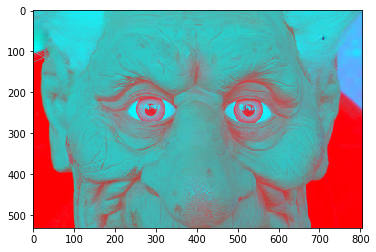

In [52]:
negative_image = negative("../app/assets/Imagens_teste/carafeia.png", mode="R")
plt.imshow(negative_image)
plt.show()

## 3. Aplicando Sobel na horizontal

In [3]:
c = Correlator()

original, padded_image, output = c.apply_sobel_filter("../app/assets/Imagens_teste/Detran_Minas-Gerais.jpg", mode="vertical")

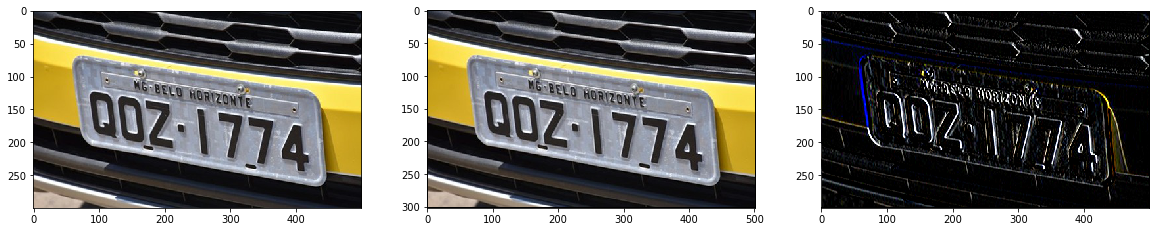

In [4]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

In [15]:
c = Correlator()

original, padded_image, output = c.apply_sobel_filter("../app/assets/Imagens_teste/einstein.png", mode="vertical")

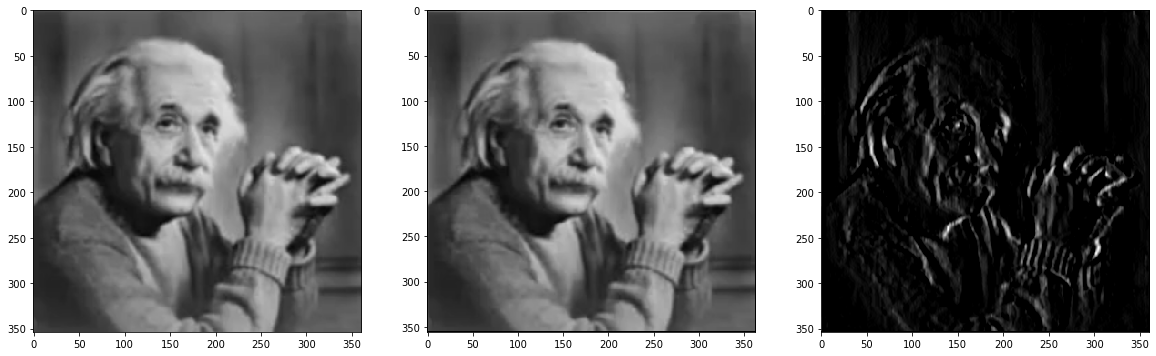

In [16]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

In [17]:
c = Correlator()

original, padded_image, output = c.apply_sobel_filter("../app/assets/Imagens_teste/einstein.png", mode="horizontal")

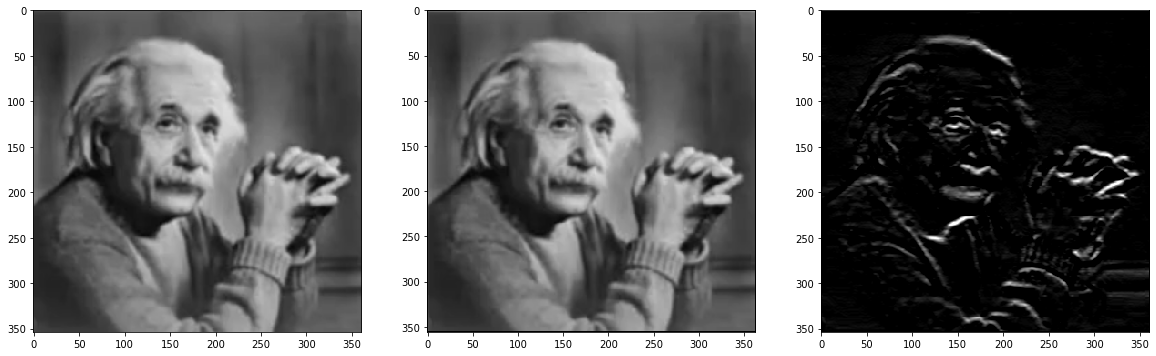

In [18]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

## 4.1 Box 25,25

In [53]:
c = Correlator()

filter_matrix = np.ones((25,25))/625

original, padded_image, output = c.apply_correlation("../app/assets/Imagens_teste/Detran_Minas-Gerais.jpg", filter_matrix)

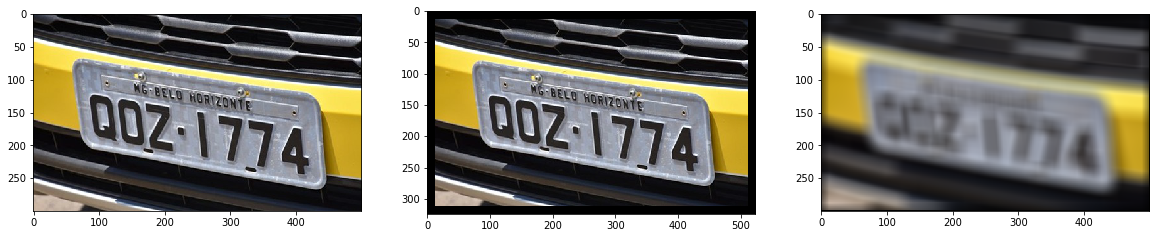

In [54]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

In [55]:
c = Correlator()

original, padded_image, output = c.apply_box_filter("../app/assets/Imagens_teste/Detran_Minas-Gerais.jpg", box_shape=(25,25))

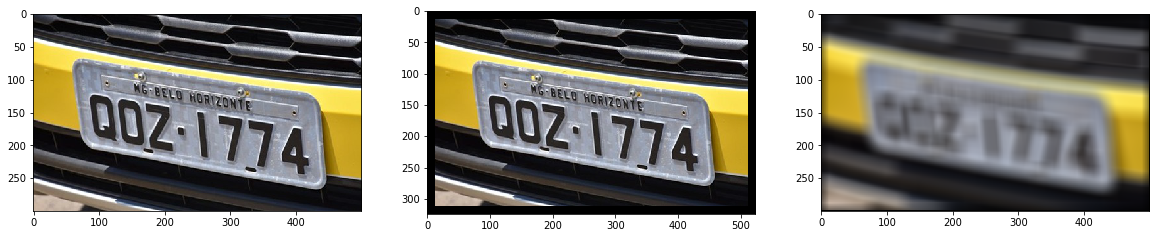

In [56]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

## 4.2 Box 25,1

In [21]:
c = Correlator()

filter_matrix = np.ones((25,1))/25

original, padded_image, output = c.apply_correlation("../app/assets/Imagens_teste/Detran_Minas-Gerais.jpg", filter_matrix)

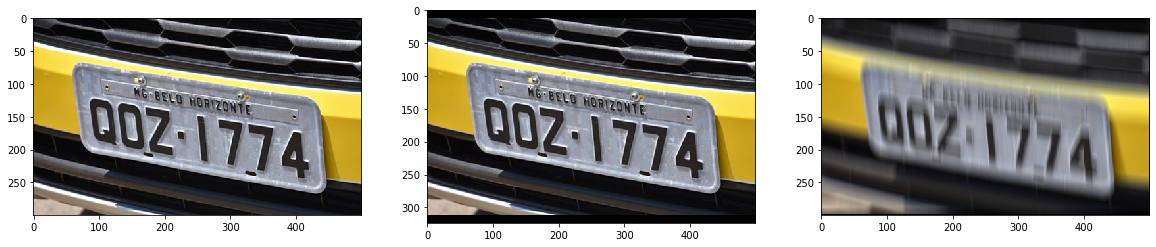

In [58]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

## 4.3 Box 1,25

In [13]:
c = Correlator()

filter_matrix = np.ones((1,25))/25

original, padded_image, output = c.apply_correlation("../app/assets/Imagens_teste/Detran_Minas-Gerais.jpg", filter_matrix)

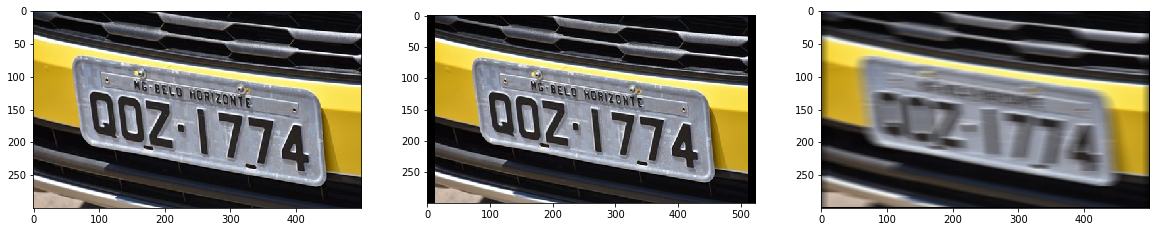

In [14]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

## Filtro mediana

In [7]:
c = Correlator()

original, padded_image, output = c.apply_box_filter("../app/assets/Imagens_teste/Detran_Minas-Gerais.jpg")

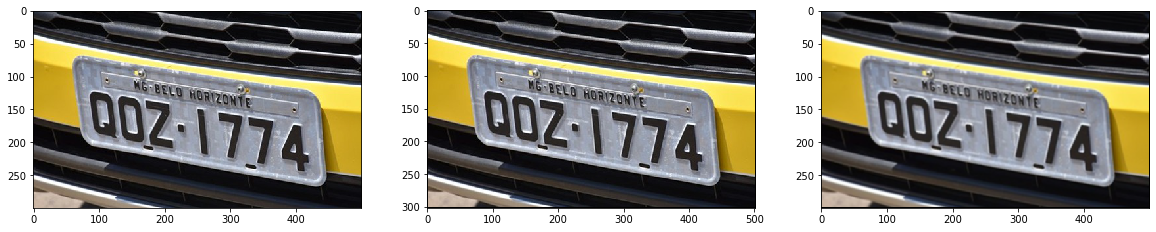

In [8]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()